# Colorectal histology - Final Project
Author: Gabriel TRUONG

## Exploratory Data Analysis

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.image_classification import colorectal_histology

2022-12-05 22:04:53.712132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 22:04:54.115131: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-05 22:04:54.128217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-05 22:04:54.128267: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

### Data Collection

In [2]:
(train_ds,train_label),(val_ds, val_label)= tfds.as_numpy(tfds.load(
    'colorectal_histology',
    split=["train[:80%]", "train[80%:]"],
    batch_size=-1,
    as_supervised=True,
))

print(type(train_ds), train_ds.shape)

2022-12-05 22:04:58.420919: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-05 22:04:58.420981: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-05 22:04:58.421025: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lapbeer): /proc/driver/nvidia/version does not exist
2022-12-05 22:04:58.421838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<class 'numpy.ndarray'> (4000, 150, 150, 3)


### Exploration

In [3]:
class_names = colorectal_histology._CLASS_NAMES
class_names

('tumor',
 'stroma',
 'complex',
 'lympho',
 'debris',
 'mucosa',
 'adipose',
 'empty')

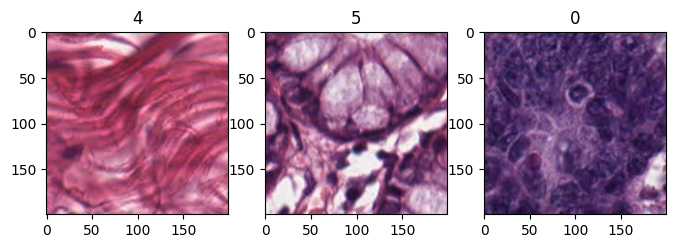

In [4]:
fig, ax = plt.subplots(1,3,figsize=(8,8))
size=(200,200)

img = [Image.fromarray(train_ds[i], 'RGB').resize(size) for i in range(4)]

ax[0].imshow(img[0],cmap = 'gray')
ax[0].set_title(train_label[0])
ax[1].imshow(img[1],cmap = 'gray')
ax[1].set_title(train_label[1])
ax[2].imshow(img[3],cmap = 'gray')
ax[2].set_title(train_label[3])
plt.show()

Text(0.5, 1.0, 'Number of occurences of a label')

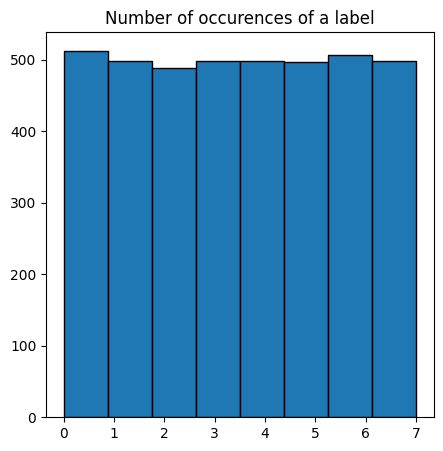

In [5]:
fig,ax = plt.subplots(figsize=(5,5))

ax.hist(train_label, bins=len(np.unique(train_label)), edgecolor="black");
ax.set_title("Number of occurences of a label")

The classes are quite balanced. It will help us when we do the confusion matrix.